In [130]:
import pandas as pd

In [131]:
df = pd.read_csv("../log/database.csv")
input_df = pd.read_csv("../log/input.csv")

In [132]:
solver_df = pd.merge(df[df.solver_version == "k-2n"], input_df, how="left", on="input_file")

In [133]:
num_cols = ["score", "duration", "n", "m", "eps", "dense"]
solver_df[num_cols].corr()

,score,duration,n,m,eps,dense
score,1.000000,0.582706,0.283986,0.604769,0.157208,-0.047750
duration,0.582706,1.000000,0.511666,0.683574,0.309946,0.022719
n,0.283986,0.511666,1.000000,0.448312,-0.042995,-0.029406
m,0.604769,0.683574,0.448312,1.000000,0.070403,-0.019868
eps,0.157208,0.309946,-0.042995,0.070403,1.000000,0.037939
dense,-0.047750,0.022719,-0.029406,-0.019868,0.037939,1.000000


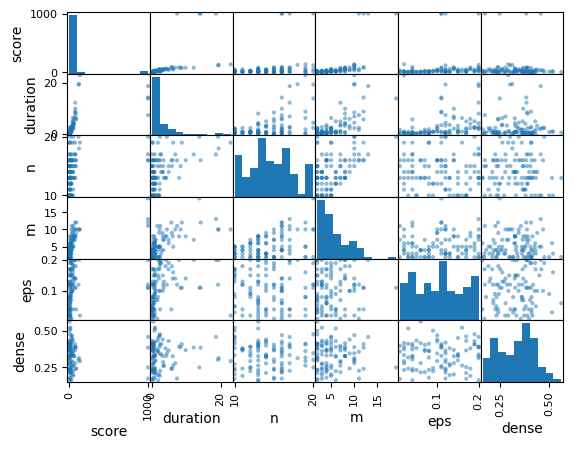

In [134]:
_ = pd.plotting.scatter_matrix(solver_df[num_cols])

<AxesSubplot:>

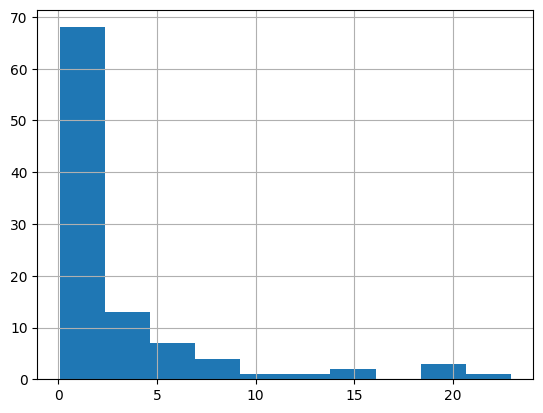

In [135]:
solver_df.duration.hist()

In [136]:
solver_df.duration.describe()

count    100.000000
mean       3.023148
std        4.575986
min        0.084600
25%        0.505500
50%        0.955350
75%        3.262125
max       22.920400
Name: duration, dtype: float64

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

df = pd.read_csv("../log/database.csv")
input_df = pd.read_csv("../log/input.csv")
solver_df = pd.merge(df[df.solver_version == "k-2n-1000"], input_df, how="left", on="input_file")

data_df = solver_df[num_cols]
data_df.loc[:, ["target"]] = data_df["duration"] > 2.

alphas = [0.5, 1.5, 2.0]

# 特徴量
for col in num_cols:
    for alpha in alphas:
        data_df.loc[:, [f"{col}^{alpha}"]] = data_df[col] ** alpha

for col1 in num_cols:
    for alpha1 in alphas:
        for col2 in num_cols:
            for alpha2 in alphas:
                c1 = f"{col1}^{alpha1}"
                c2 = f"{col2}^{alpha2}"
                data_df.loc[:, [f"{c1}*{c2}"]] = data_df[c1] * data_df[c2]
                data_df.loc[:, [f"{c1}/{c2}"]] = data_df[c1] / data_df[c2]


data_df = data_df.drop(["score", "duration"], axis=1)

x = data_df.drop(["target"], axis=1)
y = data_df["target"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

model = LogisticRegression(max_iter=1000)
model.fit(train_x, train_y)

pred_y = model.predict(test_x)
accuracy = accuracy_score(test_y, pred_y)
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
print(f"Auc:        {auc(fpr, tpr)}")
print(f"Accuracy:   {accuracy}")
print(" + ".join([f"{c:.5} {t}" for c, t in zip(model.coef_.flatten(), x.columns)]) + f" + {model.intercept_[0]:.5}")
display(pd.DataFrame(confusion_matrix(test_y, pred_y), columns=['pred0', 'pred1'], index=['y0', 'y1']))

Auc:        0.979325572059414
Accuracy:   0.98
-3.4848e-06 n + -1.2339e-06 m + -3.2517e-08 eps + -1.0254e-07 dense + -9.6095e-07 score^0.5 + -8.147e-06 score^1.5 + -2.2107e-05 score^2.0 + -9.3498e-08 duration^0.5 + 6.4728e-07 duration^1.5 + 1.3831e-06 duration^2.0 + -1.0863e-06 n^0.5 + -1.0945e-05 n^1.5 + -3.3194e-05 n^2.0 + -6.4155e-07 m^0.5 + -2.3028e-06 m^1.5 + -3.9119e-06 m^2.0 + -1.0421e-07 eps^0.5 + -1.0113e-08 eps^1.5 + -3.1072e-09 eps^2.0 + -1.8424e-07 dense^0.5 + -5.7952e-08 dense^1.5 + -3.3485e-08 dense^2.0 + -2.819e-06 score^0.5*score^0.5 + -3.3418e-07 score^0.5/score^0.5 + -2.2107e-05 score^0.5*score^1.5 + -4.8208e-08 score^0.5/score^1.5 + -5.1668e-05 score^0.5*score^2.0 + -2.0908e-08 score^0.5/score^2.0 + -2.5759e-08 score^0.5*duration^0.5 + -1.8369e-06 score^0.5/duration^0.5 + 3.4769e-06 score^0.5*duration^1.5 + -5.5576e-06 score^0.5/duration^1.5 + 7.1563e-06 score^0.5*duration^2.0 + -1.1569e-05 score^0.5/duration^2.0 + -3.0705e-06 score^0.5*n^0.5 + -2.97e-07 score^0.5/n^

/Users/tatsuyaishii/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,pred0,pred1
y0,105,1
y1,3,91


In [147]:
import lightgbm as lgb

params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "random_state": 0,
    "verbose": -1
}

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0)
train_set = lgb.Dataset(train_x, train_y)
valid_set = lgb.Dataset(valid_x, valid_y, reference=train_set)

model = lgb.train(params=params, train_set=train_set, valid_sets=[valid_set], num_boost_round=10)

pred_y = model.predict(test_x, num_iteration=model.best_iteration)
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
print(auc(fpr, tpr))

1.0
